# Goal : 
- One of the key activities of any IT function is to ensure there is no impact to the Business operations. IT leverages Incident Management process to achieve the above Objective. An incident is something that is unplanned interruption to an IT service or reduction in the quality of an IT service that affects the Users and the Business.

- Incident Management process is to provide a quick fix / workarounds or solutions that resolves the interruption and restores the service to its full capacity to ensure no business impact.

# Objective:
- Build Multi-Class classifier that can classify the tickets by analysing text.
- Guided by powerful AI techniques that can classify incidents to right functional groups can help organizations to reduce the resolving time of the issue and can focus on more productive tasks.

Auto Ticket Assignment to the right IT Functional Groups

# * Pre-Processing, Data Visualisation and EDA

#### Install necessary libraries

In [1]:
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.9 MB 14.5 MB/s 
     |████████████████████████████████| 578.0 MB 17 kB/s 
     |████████████████████████████████| 438 kB 74.8 MB/s 
     |████████████████████████████████| 5.9 MB 58.7 MB/s 
     |████████████████████████████████| 1.7 MB 66.0 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.

In [2]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 12.2 MB/s 


In [3]:
!pip install ftfy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.7 MB/s 


In [4]:
!pip install rake-nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Set the working directory

In [5]:
import zipfile
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:

def unzip_data(filename):
  
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()


In [7]:
it_ticket_path = '/content/drive/MyDrive/Datasets/it_ticket.xlsx'

unzip_data(it_ticket_path)

### Importing necessary Libraries 

In [8]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# plt.style.use('ggplot')
plt.style.use('dark_background')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
import random
import sys
from ftfy import fix_encoding, fix_text, badness

# Utilities
from time import time
from PIL import Image
from zipfile import ZipFile
import os, sys, itertools, re
import warnings, pickle, string
from ftfy import fix_encoding, fix_text, badness
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from google.colab import data_table

# NLP toolkits
import spacy
import nltk
from rake_nltk import Rake
# from nltk import tokenize

# Translation APIs
# from goslate import Goslate # Provided by Google

2.10.0


## Data Loading and Data Inspection

In [9]:
df = pd.read_excel('/content/drive/MyDrive/Datasets/it_ticket.xlsx')

In [10]:
df.head()

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,_x000D_\n_x000D_\nreceived from: hmjdrvpb.komu...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,_x000D_\n_x000D_\nreceived from: eylqgodm.ybqk...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [11]:
df.columns=['Short_description','Description', 'Caller', 'Assignment_group']

In [12]:
caller = df['Caller'].unique()

In [13]:
caller.shape

(2950,)

In [14]:
df['Description'][2]

'_x000D_\n_x000D_\nreceived from: eylqgodm.ybqkwiam@gmail.com_x000D_\n_x000D_\nhi_x000D_\n_x000D_\ni cannot log on to vpn_x000D_\n_x000D_\nbest '

In [15]:
df.shape

(8500, 4)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short_description  8492 non-null   object
 1   Description        8499 non-null   object
 2   Caller             8500 non-null   object
 3   Assignment_group   8500 non-null   object
dtypes: object(4)
memory usage: 265.8+ KB


In [17]:
# Find out the null value counts in each column
df.isnull().sum()

Short_description    8
Description          1
Caller               0
Assignment_group     0
dtype: int64

In [18]:
print(df.describe().T)

                  count unique                top  freq
Short_description  8492   7481     password reset    38
Description        8499   7817                the    56
Caller             8500   2950  bpctwhsn kzqsbmtp   810
Assignment_group   8500     74              GRP_0  3976


### Obs : 
- The dataset comprises of 8500 rows and 4 columns
- All columns are of type object containing textual information.
- There are 8 null/missing values present in the Short description and 1 null/missing values present in the description column
- Password reset is one of the most occuring tickets which reflects in the Short description column.

In [19]:
# Drop the Caller Column
df = df.drop(['Caller'], 1)

## Missing value Analysis

In [20]:
# Filtering dataset with Null values.
df[pd.isnull(df).any(axis=1)]
df

,Short_description,Description,Assignment_group
0,login issue,-verified user details.(employee# & manager na...,GRP_0
1,outlook,_x000D_\n_x000D_\nreceived from: hmjdrvpb.komu...,GRP_0
2,cant log in to vpn,_x000D_\n_x000D_\nreceived from: eylqgodm.ybqk...,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,GRP_0
4,skype error,skype error,GRP_0
...,...,...,...
8495,emails not coming in from zz mail,_x000D_\n_x000D_\nreceived from: avglmrts.vhqm...,GRP_29
8496,telephony_software issue,telephony_software issue,GRP_0
8497,vip2: windows password reset for tifpdchb pedx...,vip2: windows password reset for tifpdchb pedx...,GRP_0
8498,machine nÃ£o estÃ¡ funcionando,i am unable to access the machine utilities to...,GRP_62


In [21]:
# For Short Description
print(df[df['Short_description'].isnull()][['Short_description', 'Description']])


     Short_description                                        Description
2604               NaN  _x000D_\n_x000D_\nreceived from: ohdrnswl.rezu...
3383               NaN  _x000D_\n-connected to the user system using t...
3906               NaN  -user unable  tologin to vpn._x000D_\n-connect...
3910               NaN  -user unable  tologin to vpn._x000D_\n-connect...
3915               NaN  -user unable  tologin to vpn._x000D_\n-connect...
3921               NaN  -user unable  tologin to vpn._x000D_\n-connect...
3924               NaN  name:wvqgbdhm fwchqjor\nlanguage:\nbrowser:mic...
4341               NaN  _x000D_\n_x000D_\nreceived from: eqmuniov.ehxk...


In [22]:
# For Description
print(df[df['Description'].isnull()][['Short_description', 'Description']])


             Short_description Description
4395  i am locked out of skype         NaN


In [23]:
# # NULL replacement by empty string
# df.fillna(str(), inplace=True)

# # Replacing Null values with values from adjacent columns

# df['Short_description'].fillna(df['Description'],inplace=True)
# df['Description'].fillna(df['Short_description'],inplace=True)


## Importing and implementing RAKE(Rapid Automatic Keyword Extraction algorithm) for extracting Key phrases
* Rake extract Key phrases in a body of text by analyzing the frequency of word appearance and its co-occurance with other words in the text.

* We will group rows of simillar Key phrases and fill missing NaN values from its simillar rows

In [24]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [25]:
r = Rake()

In [26]:
# Imputing NaN values in 'Short description' based upon corresponding 'Description' values from other simillar rows in df
df.at[2604, 'Short_description'] = 'NaN'
df.at[3383, 'Short_description'] = 'NaN'
df.at[3906, 'Short_description'] = 'NaN'
df.at[3910, 'Short_description'] = 'NaN'
df.at[3915, 'Short_description'] = 'NaN'
df.at[3921, 'Short_description'] = 'NaN'
df.at[3924, 'Short_description'] = 'NaN'
df.at[4341, 'Short_description'] = 'NaN'

# Imputing NaN values in 'Description' based upon corresponding 'Description' values from other simillar rows in df
df.at[4395, 'Description'] = 'NaN'

In [27]:

def rake_implement(x) :
  r = Rake(include_repeated_phrases=False)
  r.extract_keywords_from_text(x)
  return r.get_ranked_phrases()

In [28]:
## Implimenting and Extracting Key Phrases in 'Description' and 'Short description'
df['Raked_Short_description'] = df['Short_description'].apply(rake_implement)
df['Raked_Description'] = df['Description'].apply(rake_implement)

In [29]:
## Key Phrases(od Description) for rows with missing Short description values
for i in df[df['Short_description'] == 'NaN']['Raked_Description']:
    print(i, "\n")

['_x000d_ _x000d_ _x000d_ _x000d_ link', '_x000d_ _x000d_ _x000d_ _x000d_ best', 'kindly resolve yhe issue', '_x000d_ _x000d_ received', 'com_x000d_ _x000d_ hi', 'urgent basis', 'working', 'rezuibdt', 'ohdrnswl', 'gmail'] 

['user system using teamviewer', 'user login', 'issue resolved', 'portal', 'help', 'connected', '_x000d_'] 

['user system using teamviewer', 'vpn company vpn link', 'company vpn using', 'user unable tologin', 'user login', 'issue resolved', 'vpn', 'help', 'connected', '_x000d_'] 

['user system using teamviewer', 'vpn company vpn link', 'company vpn using', 'user unable tologin', 'user login', 'issue resolved', 'vpn', 'help', 'connected', '_x000d_'] 

['user system using teamviewer', 'vpn company vpn link', 'company vpn using', 'user unable tologin', 'user login', 'issue resolved', 'vpn', 'help', 'connected', '_x000d_'] 

['user system using teamviewer', 'vpn company vpn link', 'company vpn using', 'user unable tologin', 'user login', 'issue resolved', 'vpn', 'help

In [30]:
## Corresponding 'Description values' for NaN 'Short description' rows
for ind in [2604, 3383, 3906, 3910, 3915, 3921, 3924, 4341]:
    print("---"*3, "Row Id ", ind, "---"*3)
    print(df.iloc[ind, 1], "\n")

--------- Row Id  2604 ---------
_x000D_
_x000D_
received from: ohdrnswl.rezuibdt@gmail.com_x000D_
_x000D_
hi,_x000D_
_x000D_
_x000D_
_x000D_
link is not working. kindly resolve yhe issue on urgent basis._x000D_
_x000D_
_x000D_
_x000D_
best  

--------- Row Id  3383 ---------
_x000D_
-connected to the user system using teamviewer._x000D_
-help the user login to the portal._x000D_
-issue resolved. 

--------- Row Id  3906 ---------
-user unable  tologin to vpn._x000D_
-connected to the user system using teamviewer._x000D_
-help the user login to the company vpn using the vpn company vpn link._x000D_
-issue resolved. 

--------- Row Id  3910 ---------
-user unable  tologin to vpn._x000D_
-connected to the user system using teamviewer._x000D_
-help the user login to the company vpn using the vpn company vpn link._x000D_
-issue resolved. 

--------- Row Id  3915 ---------
-user unable  tologin to vpn._x000D_
-connected to the user system using teamviewer._x000D_
-help the user login to the

In [31]:
## Corresponding 'Short description values' for NaN 'Description' rows
print("---"*3, "Row Id 4395", "---"*3)
print(df.iloc[4395, 0], "\n")

--------- Row Id 4395 ---------
i am locked out of skype 



In [32]:
## Replacing NaN Values in 'Short Description' and 'Description' with simillar values from other rows

# Imputing NaN values in 'Short description' based upon corresponding 'Description' values from other simillar rows in df
df.at[2604, 'Short_description'] = 'link not working'
df.at[3383, 'Short_description'] = 'login issue'
df.at[3906, 'Short_description'] = 'vpn login issue'
df.at[3910, 'Short_description'] = 'vpn login issue'
df.at[3915, 'Short_description'] = 'vpn login issue'
df.at[3921, 'Short_description'] = 'vpn login issue'
df.at[3924, 'Short_description'] = 'vpn login issue'
df.at[4341, 'Short_description'] = 'login failure erp'

# Imputing NaN values in 'Description' based upon corresponding 'Description' values from other simillar rows in df
df.at[4395, 'Description'] = 'i am locked out of skype'

print("Succesfully replaced all NaN values in NaN Values in 'Short Description' and 'Description' feature.")

Succesfully replaced all NaN values in NaN Values in 'Short Description' and 'Description' feature.


In [33]:
df = df.drop(['Raked_Description', 'Raked_Short_description'], 1)

In [34]:
df.isnull().sum()

Short_description    0
Description          0
Assignment_group     0
dtype: int64

In [35]:
df.count().T

Short_description    8500
Description          8500
Assignment_group     8500
dtype: int64

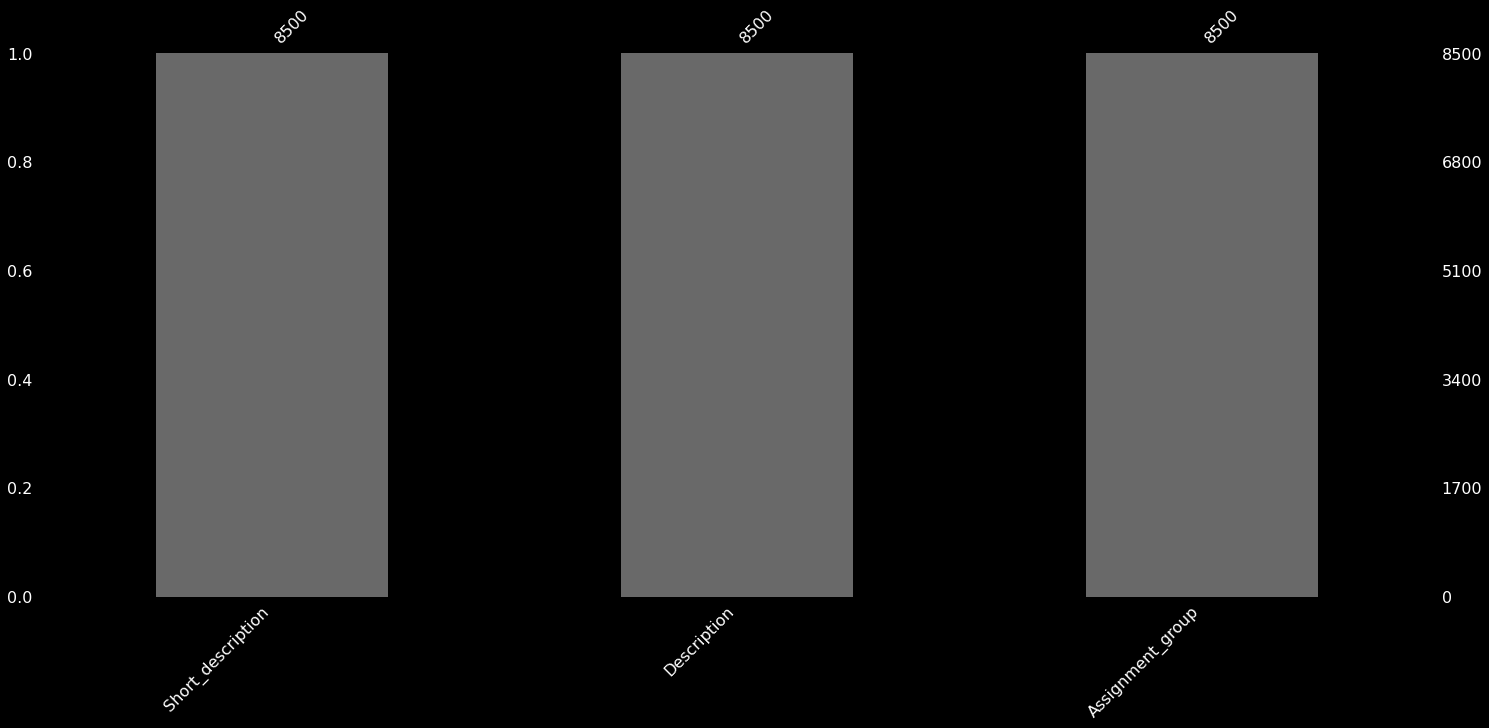

In [36]:
msno.bar(df)

### Comments : 
- Replacing NAN using RAKE

- We're not choosing to drop any record as we don't want to loose any information. And as we're going to concatenate the Short description and Description columns for each record while feeding them into NLP, we neither want to pollute the data by introducing any default values nor bias it by duplicating the description colomns.

In [37]:
# Concatenate Short description and Description
df['Complete_Description'] = df['Description'] + " " + df['Short_description']

In [38]:
# Drop the Short description and Description Column
df = df.drop(['Description','Short_description'], 1)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Assignment_group      8500 non-null   object
 1   Complete_Description  8500 non-null   object
dtypes: object(2)
memory usage: 132.9+ KB


### Observation
- Appears the Target class distrubtion is extremely skewed
Large no of entries for GRP_0 (mounting to 3976) which account for ~50% of the data
- there are groups with 1 entry also. We could merge all groups with small entries to a group to reduce the imbalance in the target. This may reduce the imbalance to some extent.

In [40]:
## Merging the test label having count less than 10   ****

sample = df.groupby(['Assignment_group'])
regroup=[]
for grp in df['Assignment_group'].unique():
  if(sample.get_group(grp).shape[0]<10):
    regroup.append(grp)
print('Found {} groups which have under 10 samples'.format(len(regroup)))
df['Assignment_group'] = df['Assignment_group'].apply(lambda x : 'misc_grp' if x in regroup  else x)

# Unique Groups check 
df['Assignment_group'].unique()

Found 25 groups which have under 10 samples


array(['GRP_0', 'GRP_1', 'GRP_3', 'GRP_4', 'GRP_5', 'GRP_6', 'GRP_7',
       'GRP_8', 'GRP_9', 'GRP_10', 'GRP_11', 'GRP_12', 'GRP_13', 'GRP_14',
       'GRP_15', 'GRP_16', 'GRP_17', 'GRP_18', 'GRP_19', 'GRP_2',
       'GRP_20', 'GRP_21', 'GRP_22', 'GRP_23', 'GRP_24', 'GRP_25',
       'GRP_26', 'GRP_27', 'GRP_28', 'GRP_29', 'GRP_30', 'GRP_31',
       'GRP_33', 'GRP_34', 'misc_grp', 'GRP_36', 'GRP_37', 'GRP_39',
       'GRP_40', 'GRP_41', 'GRP_42', 'GRP_44', 'GRP_45', 'GRP_47',
       'GRP_48', 'GRP_50', 'GRP_53', 'GRP_60', 'GRP_62', 'GRP_65'],
      dtype=object)

## Data Copy
- Before EDA we will make two copies of the dataset for traditional approach and another one for transfer learning approach

In [41]:
import copy
df1 = copy.deepcopy(df)  ## For traditional process
df2 = copy.deepcopy(df)  ## For transfer learning process

## Data Cleansing
* Fixing Garbled Text/ Mojibake/Replacing Contractions and Lemmitization

### 1. Mojibake
* Mojibake is the garbled text that is the result of text being decoded using an unintended character encoding. The result is a systematic replacement of symbols with completely unrelated ones, often from a different writing system.
* Garbled Text : If words or messages are garbled, they are not clear and are very difficult to understand, often giving a false idea of the facts
* The library ftfy (Fixes Text For You) has a greater ability to detect, fix and deal with such Mojibakes. It fixes Unicode that’s broken in various ways. The goal of ftfy is to take in bad Unicode and output good Unicode.
* Few such Mojibakes are ¶, ç, å, €, æ, œ, º, ‡, ¼, ¥ etc.

#### Mojibake Detection

In [42]:
# Write a function to apply to the dataset to detect Mojibakes
def moji_detect(text):
    if not badness.sequence_weirdness(text):
        # nothing weird, should be okay
        return True
    try:
        text.encode('sloppy-windows-1252')
    except UnicodeEncodeError:
        # Not CP-1252 encodable, probably fine
        return True
    else:
        # Encodable as CP-1252, Mojibake alert level high
        return False
    


In [43]:
# Check the dataset for mojibake impact in table format
data_table.enable_dataframe_formatter()
df1[~df1.iloc[:,:].applymap(moji_detect).all(1)]

,Assignment_group,Complete_Description
99,GRP_0,\n\nreceived from: ecprjbod.litmjwsy@gmail.com...
116,GRP_0,_x000D_\n_x000D_\nreceived from: bgqpotek.cuxa...
124,GRP_0,"from: tvcdfqgp nrbcqwgj \nsent: friday, octobe..."
162,GRP_0,_x000D_\n_x000D_\nreceived from: yfqoaepn.xnez...
164,GRP_0,\n\nreceived from: abcdri@company.com\n\nwindy...
...,...,...
8470,GRP_16,"from: mikhghytr wafglhdrhjop \nsent: thursday,..."
8471,GRP_30,to å°è´ºï¼Œæ—©ä¸Šç”µè„‘å¼€æœºå¼€ä¸å‡ºæ¥ ç”µ...
8480,GRP_9,_x000D_\n_x000D_\nreceived from: nlearzwi.ukdz...
8498,GRP_62,i am unable to access the machine utilities to...


In [44]:
# data_table.disable_dataframe_formatter()     **** Not Reqd

# # Check the dataset for mojibake impact without table format
# df[~df.iloc[:,:].applymap(moji_detect).all(1)]

##### Sample example of Mojibake

In [45]:
df1['Complete_Description'][8471]

'to å°\x8fè´ºï¼Œæ—©ä¸Šç”µè„‘å¼€æœºå¼€ä¸\x8då‡ºæ\x9d¥ ç”µè„‘å¼€æœºå¼€ä¸\x8då‡ºæ\x9d¥'

In [46]:
df1['Complete_Description'][5910]

'laptop ä»Žæ¡Œå\xad\x90ä¸Šé\x9d¢æ‘”ä¸‹ï¼Œå¤–å£³æ‘”è£‚ï¼ŒçŽ°åœ¨ä¸\x8dèƒ½å¼€æœºã€‚ laptop ä»Žæ¡Œå\xad\x90ä¸Šé\x9d¢æ‘”ä¸‹ï¼Œå¤–å£³æ‘”è£‚ï¼ŒçŽ°åœ¨ä¸\x8dèƒ½å¼€æœºã€‚'

In [47]:
df1['Complete_Description'][177]

'i try to change now my password acc. to attached e-mail but this donÂ´t work. i was out of office for vacation time until now, but_x000D_\npassword_management_tool link donÂ´t work - please help_x000D_\n_x000D_\n_x000D_\n_x000D_\nyour password expires in 13 day(s) _x000D_\n_x000D_\nthe requirement to change your password every 90 days enhances data security within company. _x000D_\n_x000D_\nplease login to _x000D_\na step-by-step guide on using the self-service tool is available here: _x000D_\n_x000D_\nplease do not reply to this email. if you require assistance, please submit a ticket to the global support center via any of these modes: _x000D_\n_x000D_\nticketing_tool: _x000D_\nemail: help@company.com _x000D_\n_x000D_\nkind  unable to access password_management_tool id password manager ijeqpkrz nwtehsyx grauw'

In [48]:
df1['Complete_Description'][7316]

'ç¼–è¾‘pptæ—¶ï¼Œæ€»æ˜¯å¼¹å‡º"æ—\xa0æ³•æ£€æŸ¥æ‹¼å†™å’Œè¯\xadæ³•é”™è¯¯"ï¼Œä¹Ÿæ—\xa0æ³•å®‰è£…ã€‚ æ‹¼å†™å’Œè¯\xadæ³•é”™è¯¯'

In [49]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Assignment_group      8500 non-null   object
 1   Complete_Description  8500 non-null   object
dtypes: object(2)
memory usage: 132.9+ KB


#### Mojibake Fixing

In [50]:
def moji_fix(data,col_num):
    j=0
#    df['mojibake'] = ''
    for i in range(data.shape[0]):
        if badness.sequence_weirdness(str(data[data.columns[col_num]][i]))!=0:
            j = j+1
            try:
                data[data.columns[col_num]][i] = fix_text(str(data[data.columns[col_num]][i]))
                data[data.columns[col_num]][i] = data[data.columns[col_num]][i].encode('sloppy-windows-1252')
                data[data.columns[col_num]][i] = fix_text(str(data[data.columns[col_num]][i]))
#                data['mojibake'][i] = badness.sequence_weirdness(data[data.columns[col_num]][i])
                
            except: Exception
        else:
            data[data.columns[col_num]][i] = data[data.columns[col_num]][i]
#            data['mojibake'][i] = badness.sequence_weirdness(data[data.columns[col_num]][i])

    return data,j

In [51]:
df1,count = moji_fix(df1,1)
print("Garbled text count: ",count)
df1,count = moji_fix(df1,1)
print("Garbled text count after Mojibake fix: ",count)

Garbled text count:  853
Garbled text count after Mojibake fix:  0


In [52]:
df1['Complete_Description'][7316]

'编辑ppt时,总是弹出"无法检查拼写和语法错误",也无法安装。 拼写和语法错误'

In [53]:
df1['Complete_Description'][164]

'\n\nreceived from: abcdri@company.com\n\nwindy shi 将撤回邮件"ticket_no1564867 -- comments added"。\n\n\n本讯息仅供指定的接收人使用,其中可能包含适用法律项下特许的、保密的和禁止披露的内容。除指定的接收人外,严禁其他任何人传播、分发或复制本讯息。如果您误收到本讯息,请通知发件人并将讯息删除。\n[\nselect the following link to view the disclaimer in an alternate language.  撤回: ticket_no1564867 -- comments added'

### Obs :
*  We're successfuly able to get the grabled characters back into their original form using ftfy.fix_text(), however it is observed that the row# 8471 is not English but Mandarine.
* So the data in our hand is multilingual and it is quite not possible to derive embeddings for mix of multiple languages. We're going to translate the entire dataset into a single language of English.

## Foreign language detection & Language Translation

### Obs : All the foreign language has been detected and translated

In [54]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Assignment_group      8500 non-null   object
 1   Complete_Description  8500 non-null   object
dtypes: object(2)
memory usage: 132.9+ KB


## Feature Engineering

### 1. train_test_validation split

In [55]:
df1['Assignment_group'].value_counts()

GRP_0       3976
GRP_8        661
GRP_24       289
GRP_12       257
GRP_9        252
GRP_2        241
GRP_19       215
GRP_3        200
GRP_6        184
GRP_13       145
GRP_10       140
GRP_5        129
GRP_14       118
GRP_25       116
GRP_33       107
GRP_4        100
GRP_29        97
GRP_18        88
misc_grp      87
GRP_16        85
GRP_17        81
GRP_31        69
GRP_7         68
GRP_34        62
GRP_26        56
GRP_40        45
GRP_28        44
GRP_41        40
GRP_30        39
GRP_15        39
GRP_42        37
GRP_20        36
GRP_45        35
GRP_22        31
GRP_1         31
GRP_11        30
GRP_21        29
GRP_47        27
GRP_23        25
GRP_62        25
GRP_48        25
GRP_60        20
GRP_39        19
GRP_27        18
GRP_37        16
GRP_44        15
GRP_36        15
GRP_50        14
GRP_53        11
GRP_65        11
Name: Assignment_group, dtype: int64

#### Note :You cannot perform a stratified split as there is value that are present only once so they cannot have an even repartitions in train and test set.

Once solution would be to bin this continuous variable into intervals using KBinsDiscretizer and perform the stratified split on it as follows:

In [56]:
sample = df1.groupby(['Assignment_group'])
regroup=[]
for grp in df1['Assignment_group'].unique():
  if(sample.get_group(grp).shape[0]<10):
    regroup.append(grp)
print('Found {} groups which have under 10 samples'.format(len(regroup)))
df1['Assignment_group']=df1['Assignment_group'].apply(lambda x : 'misc_grp' if x in regroup  else x)

Found 0 groups which have under 10 samples


In [57]:
# Import label encoder 
from sklearn.preprocessing import LabelEncoder

# label_encoder object knows how to understand word labels. 
label_encoder = LabelEncoder()
df1['Assignment_group']= label_encoder.fit_transform(df1['Assignment_group'])
# X = df1.drop('Assignment_group', axis=1)
# # Encode labels in column 'species'. 
# y = label_encoder.fit_transform(df1.Assignment_group)


In [58]:
df1['Assignment_group'].value_counts()

0     3976
47     661
17     289
4      257
48     252
12     241
11     215
23     200
42     184
5      145
2      140
39     129
6      118
18     116
26     107
31     100
22      97
10      88
49      87
8       85
9       81
25      69
46      68
27      62
19      56
32      45
21      44
33      40
24      39
7       39
34      37
13      36
36      35
15      31
1       31
3       30
14      29
37      27
16      25
44      25
38      25
43      20
30      19
20      18
29      16
35      15
28      15
40      14
41      11
45      11
Name: Assignment_group, dtype: int64

In [59]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Assignment_group      8500 non-null   int64 
 1   Complete_Description  8500 non-null   object
dtypes: int64(1), object(1)
memory usage: 132.9+ KB


In [60]:
df1.shape

(8500, 2)

In [61]:
df1['Assignment_group'].nunique()

50

In [62]:
df1['Assignment_group'].unique()

array([ 0,  1, 23, 31, 39, 42, 46, 47, 48,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27,
       49, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 40, 41, 43, 44, 45])

In [63]:
from sklearn.preprocessing import KBinsDiscretizer
est = KBinsDiscretizer(n_bins=50, encode='ordinal', strategy='uniform')
new = est.fit_transform(df1[['Assignment_group']])

In [64]:
new.dtype

dtype('float64')

In [65]:
# new = new.astype('int32')

In [66]:
# new.dtype

In [67]:
len(np.unique(new))

50

In [68]:
# np.unique(new)

In [69]:
## Dev and Test Split on whole dataset
from sklearn.model_selection import train_test_split

df1_dev, df1_test = train_test_split(df1, test_size = 0.1,stratify = new,  random_state = 42)

In [70]:
df1_dev.shape, df1_test.shape

((7650, 2), (850, 2))

In [71]:
df1_dev['Assignment_group'].nunique()

50

In [72]:
est1 = KBinsDiscretizer(n_bins=50, encode='ordinal', strategy='uniform')
new1 = est1.fit_transform(df1_dev[['Assignment_group']])

In [73]:
## Train and Valid split on Dev data
df1_train, df1_valid = train_test_split(df1_dev, test_size = 0.1,stratify = df1_dev['Assignment_group'], random_state = 42)

In [74]:
df1_train.shape, df1_valid.shape

((6885, 2), (765, 2))

In [75]:
df1_train['Assignment_group'].nunique()

50

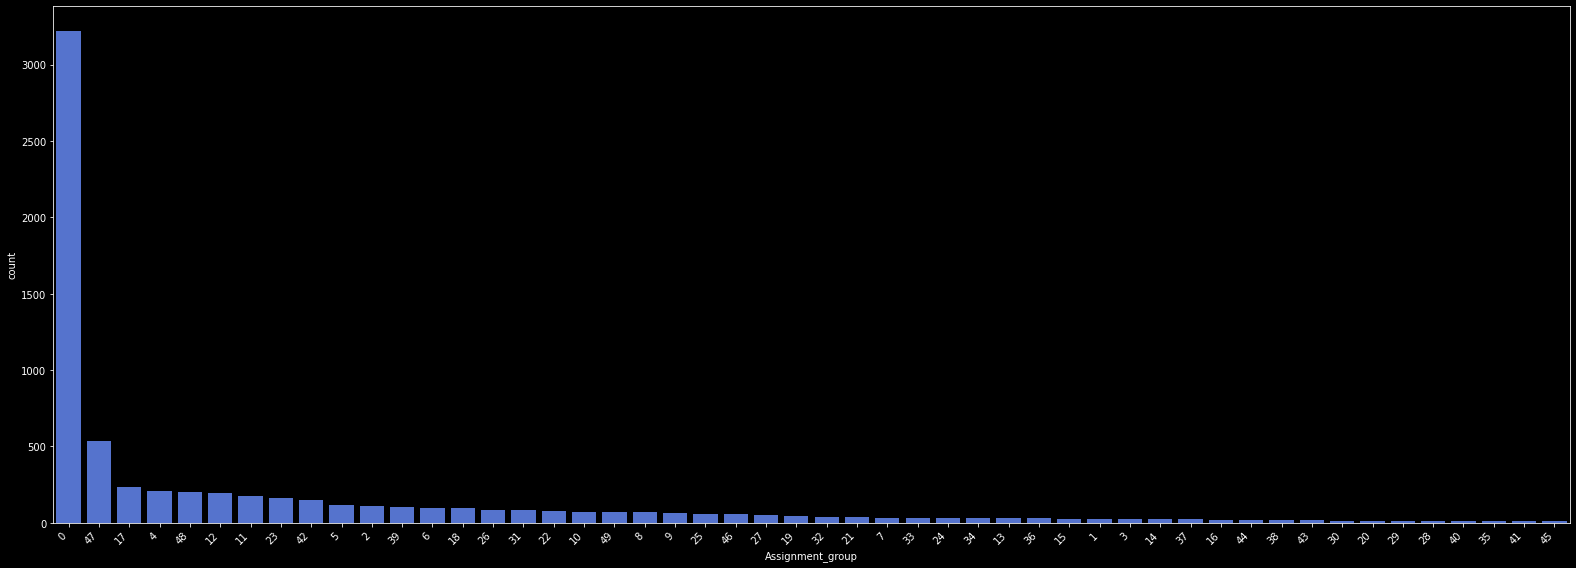

In [76]:
## Pre-Processing label Encoding on  Assignment Group    ****

descending_order = df1_train['Assignment_group'].value_counts().sort_values(ascending = False).index
plt.subplots(figsize = (22,8))
#added code for x label rotate 
# data_train.value_counts()[:].sort_values(ascending = False).plot(kind='bar', ax=axs[0, 1])
ax = sns.countplot(x = 'Assignment_group', data = df1_train, color = 'royalblue',order = descending_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = "right")
plt.tight_layout()
plt.show()

In [77]:
df1_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6885 entries, 6003 to 5536
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Assignment_group      6885 non-null   int64 
 1   Complete_Description  6885 non-null   object
dtypes: int64(1), object(1)
memory usage: 419.4+ KB


In [78]:
df1_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 765 entries, 2202 to 1475
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Assignment_group      765 non-null    int64 
 1   Complete_Description  765 non-null    object
dtypes: int64(1), object(1)
memory usage: 17.9+ KB


In [79]:
df1_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 850 entries, 5954 to 4798
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Assignment_group      850 non-null    int64 
 1   Complete_Description  850 non-null    object
dtypes: int64(1), object(1)
memory usage: 19.9+ KB


In [80]:
df1_train['Assignment_group'].value_counts()

0     3220
47     536
17     234
4      208
48     204
12     195
11     175
23     162
42     149
5      117
2      113
39     104
6       95
18      94
26      86
31      81
22      78
10      71
49      70
8       69
9       66
25      56
46      55
27      50
19      45
32      37
21      36
24      32
7       32
33      32
34      30
13      29
36      29
15      25
1       25
3       24
14      23
37      22
44      21
38      21
16      21
43      16
30      15
20      14
29      13
28      13
40      12
35      12
41       9
45       9
Name: Assignment_group, dtype: int64

In [81]:
from collections import Counter

In [82]:
from imblearn.over_sampling import RandomOverSampler

In [83]:
len(df1_train['Assignment_group'])

6885

In [84]:
ros = RandomOverSampler(random_state = 42,sampling_strategy='minority')
X_train_res, y_train_res = ros.fit_resample(df1_train['Complete_Description'].values.reshape(-1, 1), df1_train['Assignment_group'].values.reshape(-1, 1))


In [85]:
# from imblearn.over_sampling import SMOTE
# smote = SMOTE(random_state=43)
# X_train_smt, y_train_smt = smote.fit_resample(df1_train['Complete_Description'].values.reshape(-1, 1), df1_train['Assignment_group'].values.reshape(-1, 1))

In [86]:
np.unique(y_train_res)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [87]:
len(y_train_res)

10096

In [88]:
Counter(y_train_res)

Counter({0: 3220,
         47: 536,
         6: 95,
         5: 117,
         49: 70,
         17: 234,
         31: 81,
         9: 66,
         4: 208,
         23: 162,
         18: 94,
         39: 104,
         26: 86,
         11: 175,
         21: 36,
         12: 195,
         42: 149,
         22: 78,
         33: 32,
         48: 204,
         27: 50,
         14: 23,
         30: 15,
         24: 32,
         2: 113,
         28: 13,
         10: 71,
         35: 12,
         1: 25,
         25: 56,
         36: 29,
         20: 14,
         29: 13,
         8: 69,
         15: 25,
         38: 21,
         46: 55,
         19: 45,
         7: 32,
         40: 12,
         3: 24,
         37: 22,
         16: 21,
         13: 29,
         44: 21,
         34: 30,
         41: 3220,
         45: 9,
         32: 37,
         43: 16})

In [89]:
len(X_train_res)

10096

In [90]:
X_train_res.shape

(10096, 1)

In [91]:
y_train_res.shape

(10096,)

In [92]:
X_train_res[0]

array(['800\nsummary:need help gaining access to a query in SID_37. i can get into SID_37, i can get into be analyzer, i can find the query name i am looking for (csr quote count) but when i try to open it i get a error message that reads: a critical programdnty error has occurred. the programdnty will now terminate. i need access this week for training that i have scheduled erp SID_37 issue '],
      dtype=object)

In [93]:
## Creating Feature space and target vector for all data

## Creating the feature space               
X_valid = df1_valid.drop('Assignment_group',axis = 1)
X_test = df1_test.drop('Assignment_group',axis = 1)

## Creating target variable                             
y_valid = df1_valid['Assignment_group']
y_test = df1_test['Assignment_group']

## Importing Lib

In [94]:
## Importing necessary libraries
%%time
from sklearn import preprocessing
from sklearn import metrics

# Tools & Evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report, auc
from sklearn.metrics import roc_curve, accuracy_score, precision_recall_curve, precision_recall_fscore_support

from sklearn.pipeline import Pipeline


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, Input, Dense, GlobalAveragePooling1D,Lambda, LSTM, GRU, Bidirectional, Conv1D, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D, BatchNormalization,SpatialDropout1D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adadelta, Adagrad, Adamax, Nadam
from tensorflow_addons.optimizers import AdamW, RectifiedAdam
## from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Activation, BatchNormalization, UpSampling1D
# from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

import tensorflow_hub as hub
import tensorflow_text as text


CPU times: user 133 ms, sys: 16 ms, total: 149 ms
Wall time: 155 ms


#### Note : numpy. ravel(), which is used to change a 2-dimensional array or a multi-dimensional array into a contiguous flattened array. The returned array has the same data type as the source array or input array.

In [95]:
OOV_TOKEN = "<OOV>"
MAX_VOCAB_LENGTH = 20000  # max number of words to have in our vocabulary ideal use len(tokenizer.word_index + 1)
MAX_SEQUENCE_LENGTH = 200  ## it will equalise all the array
PADDING = 'post'

In [96]:
# Use Tokenizer to convert the words to tokens
tokenizer = Tokenizer(num_words = MAX_VOCAB_LENGTH, oov_token = OOV_TOKEN)   
## convert words into tokens
## num_words is nothing but your vocabulary size

tokenizer.fit_on_texts(X_train_res.ravel())  ## fit_on_texts only on train not for validation and test



In [97]:
#Get the vocabulary size
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 21146 unique tokens.


In [98]:
## convert the sequence of word in sequence of numbers 
X_train_token = tokenizer.texts_to_sequences(X_train_res.ravel()) ## sequence of word in sequence of numbers
X_valid_token = tokenizer.texts_to_sequences(np.array(X_valid).ravel())
X_test_token = tokenizer.texts_to_sequences(np.array(X_test).ravel())

In [99]:
# Apply padding
 
X_train_pad = pad_sequences(X_train_token, padding = PADDING, maxlen = MAX_SEQUENCE_LENGTH)
X_valid_pad = pad_sequences(X_valid_token, padding = PADDING, maxlen = MAX_SEQUENCE_LENGTH)
X_test_pad = pad_sequences(X_test_token, padding = PADDING, maxlen = MAX_SEQUENCE_LENGTH)

In [100]:
VOCAB_SIZE = len(word_index) + 1   # Adding 1 because of reserved 0 index

In [101]:
EMBEDDING_SIZE = 256

In [102]:
X_train_pad.shape

(10096, 200)

In [103]:
embedding = Embedding(input_dim = VOCAB_SIZE, ## Size of the vocabulary
                             output_dim = EMBEDDING_SIZE, ## Length of the vector for each word or the size of the dense vector
                             embeddings_initializer = "uniform", 
                             input_length = MAX_SEQUENCE_LENGTH )  ## Maximum length of a sequence

embedding

In [104]:
num_class = len(np.unique(y_train_res))
num_class

50

In [105]:
# Plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

In [106]:
def calculate_results(model,X, y):

  score = model.evaluate(X, y, verbose=1)
  # Create a dictionary of model results
  model_results = {"Test Accuracy %ge": round(score[1]*100,3),
                   "Test Loss Score": round(score[0],5)}
  return model_results


## Model_1 : Simple ANN

Model: "Model_1_Simple_ANN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 main_input (InputLayer)     [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 256)          5413632   
                                                                 
 global_average_pooling1d (G  (None, 256)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 50)                3250      
                                                                 
Total params: 5,433,330
Trainable params: 5,433,330
Non-trainable params: 0
______________________________________

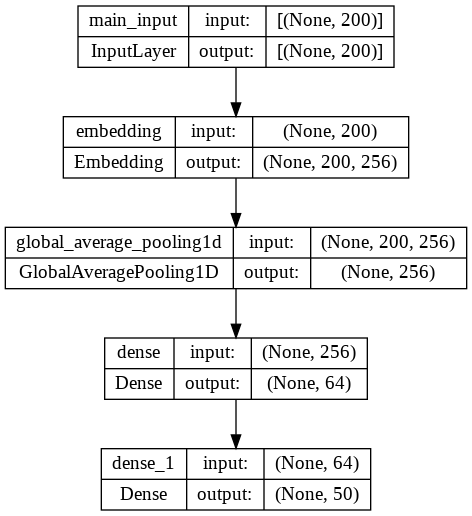

In [107]:
# Build model with the Functional API

inputs = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype = 'int32', name='main_input') # 
# x = text_vectorizer(inputs) # turn the input text into numbers 
x = embedding(inputs)  ## create an embedding of the numberised inputs
x = GlobalAveragePooling1D()(x)  ## condense the feature vector for each token to one vector
x = Dense(64, activation = 'relu')(x)
outputs = Dense(num_class, activation='softmax')(x)
## Initialize the model
model_1 = Model(inputs, outputs, name = "Model_1_Simple_ANN") # construct the model

## Summarize layers
print(model_1.summary())

## Plot graph
plot_model(model_1, to_file='Model_1_Simple_ANN_plot.png', show_shapes=True, show_layer_names=True)


In [108]:
# Compile model
model_1.compile(loss = 'sparse_categorical_crossentropy',
                optimizer = Nadam(),
                metrics = ["accuracy"])

# Fit the model
history_1 = model_1.fit(X_train_pad,
                        y_train_res, 
                        epochs = 20,
                        validation_data = (X_valid_pad, y_valid)
                        )

Epoch 1/20
316/316 [==============================] - 5s 7ms/step - loss: 2.1179 - accuracy: 0.5544 - val_loss: 2.2519 - val_accuracy: 0.5320
Epoch 2/20
316/316 [==============================] - 2s 6ms/step - loss: 1.4599 - accuracy: 0.6832 - val_loss: 2.0055 - val_accuracy: 0.5359
Epoch 3/20
316/316 [==============================] - 2s 6ms/step - loss: 1.3153 - accuracy: 0.6921 - val_loss: 1.8692 - val_accuracy: 0.5503
Epoch 4/20
316/316 [==============================] - 2s 6ms/step - loss: 1.2099 - accuracy: 0.7133 - val_loss: 1.7676 - val_accuracy: 0.5804
Epoch 5/20
316/316 [==============================] - 1s 5ms/step - loss: 1.1160 - accuracy: 0.7269 - val_loss: 1.7095 - val_accuracy: 0.5935
Epoch 6/20
316/316 [==============================] - 2s 5ms/step - loss: 1.0367 - accuracy: 0.7357 - val_loss: 1.6366 - val_accuracy: 0.6052
Epoch 7/20
316/316 [==============================] - 1s 5ms/step - loss: 0.9652 - accuracy: 0.7477 - val_loss: 1.6379 - val_accuracy: 0.6039
Epoch 

In [109]:
model_1_results = calculate_results(model_1,X_test_pad, y_test)
model_1_results

27/27 [==============================] - 0s 3ms/step - loss: 1.5573 - accuracy: 0.6647


{'Test Accuracy %ge': 66.471, 'Test Loss Score': 1.5573}

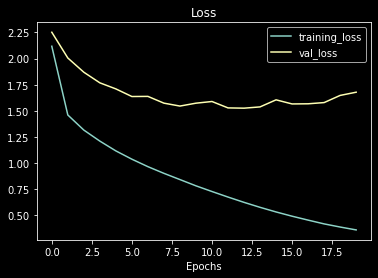

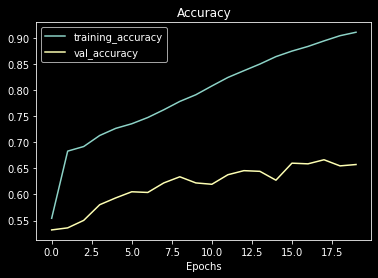

In [110]:
plot_loss_curves(history_1)

## Model_2 : LSTM

Model: "Model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 main_input (InputLayer)     [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 256)          5413632   
                                                                 
 lstm (LSTM)                 (None, 200, 128)          197120    
                                                                 
 global_average_pooling1d_1   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 50)                3250      
                                                      

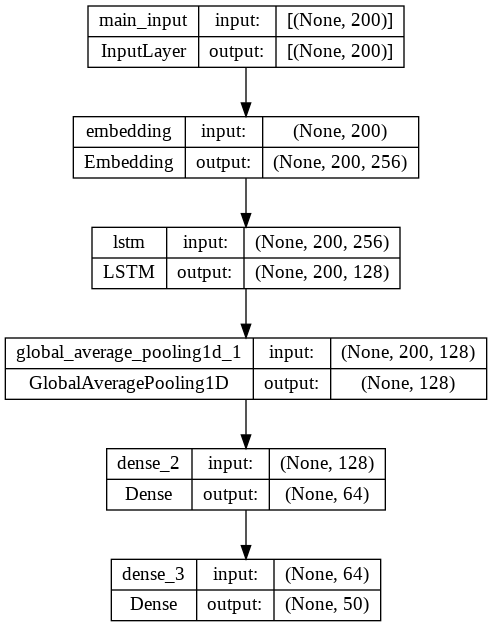

In [111]:
# Build model with the Functional API

inputs = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype = 'int32', name='main_input') # 
x = embedding(inputs)  ## create an embedding of the numberised inputs
x = LSTM(128, return_sequences=True)(x)
x = GlobalAveragePooling1D()(x)
x = Dense(64, activation = 'relu')(x)
outputs = Dense(num_class, activation='softmax')(x)
## Initialize the model
model_2 = Model(inputs, outputs, name = "Model_2_LSTM") # construct the model

## Summarize layers
print(model_2.summary())

## Plot graph
plot_model(model_2, to_file='Model_2_LSTM_plot.png', show_shapes=True, show_layer_names=True)

In [112]:
# Compile model
model_2.compile(loss = 'sparse_categorical_crossentropy',
                optimizer = Adam(lr= 0.0015),
                metrics = ["accuracy"])

# Fit the model
history_2 = model_2.fit(X_train_pad,
                        y_train_res,
                        epochs = 20,
                        validation_data = (X_valid_pad, y_valid)
                        )

Epoch 1/20
316/316 [==============================] - 8s 16ms/step - loss: 1.5267 - accuracy: 0.6615 - val_loss: 1.9630 - val_accuracy: 0.5569
Epoch 2/20
316/316 [==============================] - 4s 14ms/step - loss: 1.0513 - accuracy: 0.7378 - val_loss: 1.7074 - val_accuracy: 0.5908
Epoch 3/20
316/316 [==============================] - 4s 14ms/step - loss: 0.8416 - accuracy: 0.7750 - val_loss: 1.7917 - val_accuracy: 0.5895
Epoch 4/20
316/316 [==============================] - 4s 14ms/step - loss: 0.6332 - accuracy: 0.8224 - val_loss: 1.8297 - val_accuracy: 0.6078
Epoch 5/20
316/316 [==============================] - 4s 14ms/step - loss: 0.4612 - accuracy: 0.8698 - val_loss: 1.7600 - val_accuracy: 0.6379
Epoch 6/20
316/316 [==============================] - 4s 14ms/step - loss: 0.3333 - accuracy: 0.9082 - val_loss: 2.0183 - val_accuracy: 0.6065
Epoch 7/20
316/316 [==============================] - 4s 14ms/step - loss: 0.2505 - accuracy: 0.9333 - val_loss: 2.2199 - val_accuracy: 0.6235

In [113]:
model_2_results = calculate_results(model_2,X_test_pad, y_test)
model_2_results

27/27 [==============================] - 0s 5ms/step - loss: 3.1503 - accuracy: 0.6424


{'Test Accuracy %ge': 64.235, 'Test Loss Score': 3.1503}

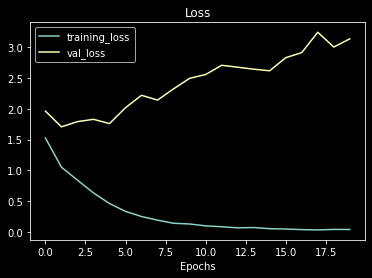

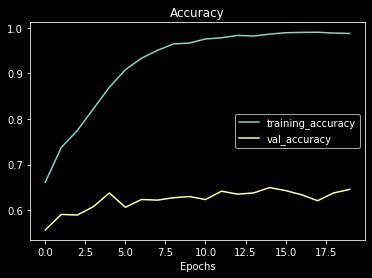

In [114]:
plot_loss_curves(history_2)

## Model_3: GRU

Model: "Model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 main_input (InputLayer)     [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 256)          5413632   
                                                                 
 gru (GRU)                   (None, 200, 128)          148224    
                                                                 
 batch_normalization (BatchN  (None, 200, 128)         512       
 ormalization)                                                   
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                       

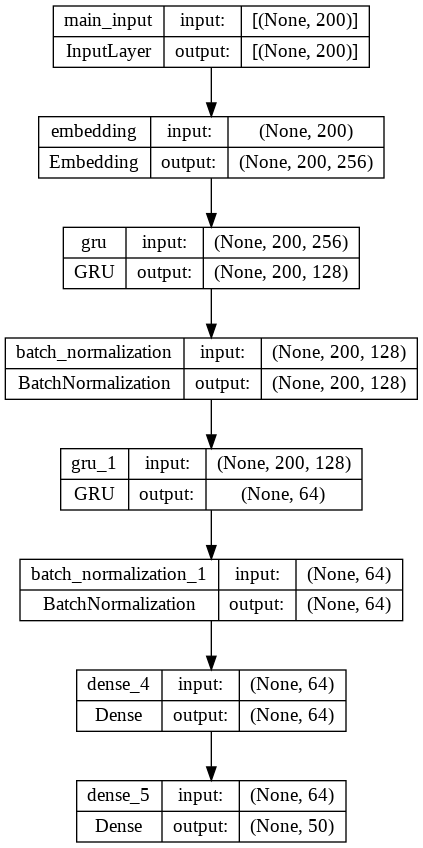

In [116]:
# Build model with the Functional API

inputs = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype = 'int32', name='main_input') # 
x = embedding(inputs)  ## create an embedding of the numberised inputs
x = GRU(128, return_sequences=True)(x)
x = BatchNormalization()(x)
# x = Dropout(0.2)(x)
x = GRU(64)(x)
x = BatchNormalization()(x)
# x = Dropout(0.2)(x)
x = Dense(64, activation = 'relu')(x)
outputs = Dense(num_class, activation='softmax')(x)
## Initialize the model
model_3 = Model(inputs, outputs, name = "Model_3_GRU") # construct the model

## Summarize layers
print(model_3.summary())

## Plot graph
plot_model(model_3, to_file='Model_3_GRU_plot.png', show_shapes=True, show_layer_names=True)

In [117]:
# Compile model
model_3.compile(loss = 'sparse_categorical_crossentropy',
                optimizer = Nadam(),
                metrics = ["accuracy"])

# Fit the model
history_3 = model_3.fit(X_train_pad,
                        y_train_res,
                        epochs = 20,
                        validation_data = (X_valid_pad, y_valid)
                        )

Epoch 1/20
316/316 [==============================] - 12s 22ms/step - loss: 1.5054 - accuracy: 0.6584 - val_loss: 2.8778 - val_accuracy: 0.3176
Epoch 2/20
316/316 [==============================] - 6s 19ms/step - loss: 0.3678 - accuracy: 0.9051 - val_loss: 2.0698 - val_accuracy: 0.6366
Epoch 3/20
316/316 [==============================] - 6s 20ms/step - loss: 0.1737 - accuracy: 0.9551 - val_loss: 1.9842 - val_accuracy: 0.6340
Epoch 4/20
316/316 [==============================] - 6s 20ms/step - loss: 0.1223 - accuracy: 0.9692 - val_loss: 2.1935 - val_accuracy: 0.6288
Epoch 5/20
316/316 [==============================] - 6s 19ms/step - loss: 0.0912 - accuracy: 0.9766 - val_loss: 2.5356 - val_accuracy: 0.6092
Epoch 6/20
316/316 [==============================] - 6s 20ms/step - loss: 0.0663 - accuracy: 0.9828 - val_loss: 2.5696 - val_accuracy: 0.5830
Epoch 7/20
316/316 [==============================] - 6s 20ms/step - loss: 0.0560 - accuracy: 0.9841 - val_loss: 2.2263 - val_accuracy: 0.660

In [118]:
model_3_results = calculate_results(model_3,X_test_pad, y_test)
model_3_results

27/27 [==============================] - 0s 12ms/step - loss: 3.0819 - accuracy: 0.6624


{'Test Accuracy %ge': 66.235, 'Test Loss Score': 3.08186}

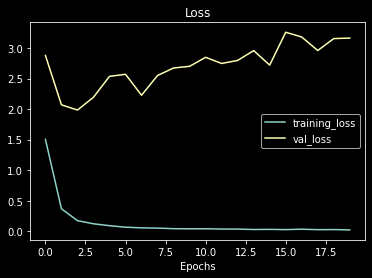

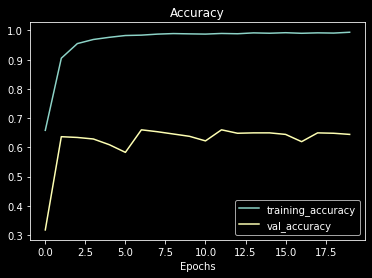

In [119]:
plot_loss_curves(history_3)

## Model_4 : Bidirectional RNN with stacked LSTM & GRU

Model: "Model_4_Bidriectional_RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 main_input (InputLayer)     [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 256)          5413632   
                                                                 
 bidirectional (Bidirectiona  (None, 200, 256)         394240    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              123648    
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 50)  

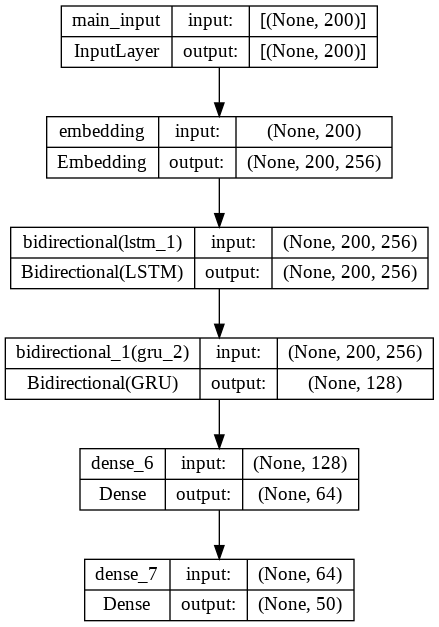

In [120]:
# Build model with the Functional API

inputs = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype = 'int32', name='main_input') # 
x = embedding(inputs)  ## create an embedding of the numberised inputs
x = Bidirectional(LSTM(128, return_sequences = True))(x)
x = Bidirectional(GRU(64))(x)

x = Dense(64, activation = 'relu')(x)

outputs = Dense(num_class, activation='softmax')(x)
## Initialize the model
model_4 = Model(inputs, outputs, name = "Model_4_Bidriectional_RNN") # construct the model

## Summarize layers
print(model_4.summary())

## Plot graph
plot_model(model_4, to_file='Model_4_Bidriectional_RNN_plot.png', show_shapes=True, show_layer_names=True)

In [121]:
# Compile model
model_4.compile(loss = 'sparse_categorical_crossentropy',
                optimizer = RMSprop(lr = 0.0001),
                metrics = ["accuracy"])

# Fit the model
history_4 = model_4.fit(X_train_pad,
                        y_train_res,
                        epochs = 20,
                        validation_data = (X_valid_pad, y_valid)
                        )

Epoch 1/20
316/316 [==============================] - 18s 37ms/step - loss: 1.7366 - accuracy: 0.6582 - val_loss: 2.0061 - val_accuracy: 0.5503
Epoch 2/20
316/316 [==============================] - 10s 32ms/step - loss: 1.0879 - accuracy: 0.7357 - val_loss: 1.8761 - val_accuracy: 0.5582
Epoch 3/20
316/316 [==============================] - 10s 32ms/step - loss: 0.9149 - accuracy: 0.7723 - val_loss: 1.7953 - val_accuracy: 0.5634
Epoch 4/20
316/316 [==============================] - 10s 32ms/step - loss: 0.7876 - accuracy: 0.8074 - val_loss: 1.8068 - val_accuracy: 0.5608
Epoch 5/20
316/316 [==============================] - 11s 33ms/step - loss: 0.6779 - accuracy: 0.8359 - val_loss: 1.7133 - val_accuracy: 0.6118
Epoch 6/20
316/316 [==============================] - 10s 32ms/step - loss: 0.5805 - accuracy: 0.8613 - val_loss: 1.6958 - val_accuracy: 0.6118
Epoch 7/20
316/316 [==============================] - 10s 32ms/step - loss: 0.4990 - accuracy: 0.8826 - val_loss: 1.6509 - val_accuracy:

In [122]:
model_4_results = calculate_results(model_4,X_test_pad, y_test)
model_4_results

27/27 [==============================] - 0s 14ms/step - loss: 2.0901 - accuracy: 0.6424


{'Test Accuracy %ge': 64.235, 'Test Loss Score': 2.09015}

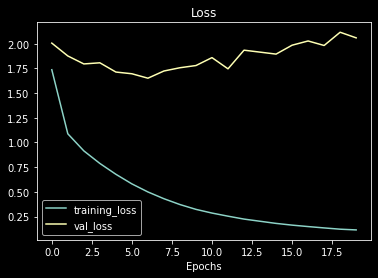

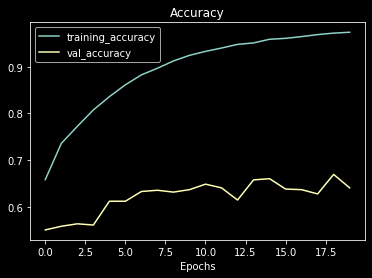

In [123]:
plot_loss_curves(history_4)

## Model_5: Pretrained Model (universal-sentence-encoder-large)

In [124]:
embed_usel = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")
embed_usel

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7f0fd50d29d0>

Model: "Model_5_USEL"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 keras_layer (KerasLayer)    (None, 512)               147354880 
                                                                 
 dense_8 (Dense)             (None, 128)               65664     
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 50)                3250      
                                                                 
Total params: 147,432,050
Trainable params: 77,170
Non-trainable params: 147,354,880
_________________________________________________________________
None


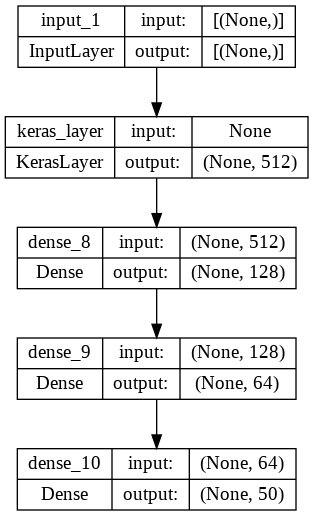

In [125]:
inputs = Input(shape=(), dtype=tf.string)
embedding = hub.KerasLayer(embed_usel, 
                    trainable = False)(inputs)
x = Dense(128, activation='relu')(embedding)
x = Dense(64, activation = 'relu')(x)
outputs = Dense(num_class, activation='softmax')(x)

## Initialize the model
model_5 = Model(inputs, outputs, name = "Model_5_USEL") # construct the model

## Summarize layers
print(model_5.summary())

## Plot graph
plot_model(model_5, to_file='Model_5_USEL_plot.png', show_shapes=True, show_layer_names=True)

In [126]:
# Compile model
model_5.compile(loss = 'sparse_categorical_crossentropy',
                optimizer = Nadam(),
                metrics = ["accuracy"])

# Fit the model
history_5 = model_5.fit(X_train_res,    ## note about X_train not like other model
                        y_train_res,
                        epochs = 20,
                        validation_data = (X_valid, y_valid)
                        )

Epoch 1/20
316/316 [==============================] - 62s 106ms/step - loss: 1.5857 - accuracy: 0.6590 - val_loss: 1.7149 - val_accuracy: 0.5752
Epoch 2/20
316/316 [==============================] - 28s 89ms/step - loss: 1.0784 - accuracy: 0.7256 - val_loss: 1.4687 - val_accuracy: 0.6065
Epoch 3/20
316/316 [==============================] - 28s 87ms/step - loss: 0.9358 - accuracy: 0.7443 - val_loss: 1.3572 - val_accuracy: 0.6235
Epoch 4/20
316/316 [==============================] - 28s 87ms/step - loss: 0.8486 - accuracy: 0.7593 - val_loss: 1.3058 - val_accuracy: 0.6248
Epoch 5/20
316/316 [==============================] - 29s 91ms/step - loss: 0.7814 - accuracy: 0.7708 - val_loss: 1.2580 - val_accuracy: 0.6353
Epoch 6/20
316/316 [==============================] - 27s 85ms/step - loss: 0.7279 - accuracy: 0.7842 - val_loss: 1.2483 - val_accuracy: 0.6379
Epoch 7/20
316/316 [==============================] - 28s 87ms/step - loss: 0.6788 - accuracy: 0.7968 - val_loss: 1.2622 - val_accuracy

In [127]:
model_5_results = calculate_results(model_5,X_test, y_test)
model_5_results

27/27 [==============================] - 2s 80ms/step - loss: 1.5298 - accuracy: 0.6435


{'Test Accuracy %ge': 64.353, 'Test Loss Score': 1.52984}

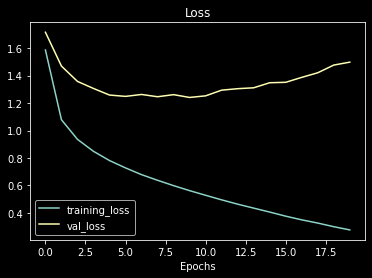

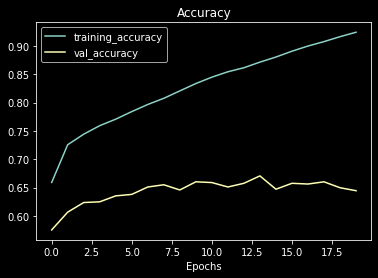

In [128]:
plot_loss_curves(history_5)

## Model_6: universal-sentence-encoder-multilingual (USEM)

In [129]:
embed_usem = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")
embed_usem

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7f0f8e8dc790>

Model: "Model_6_USEM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 keras_layer_1 (KerasLayer)  (None, 512)               68927232  
                                                                 
 dense_11 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization_2 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                      

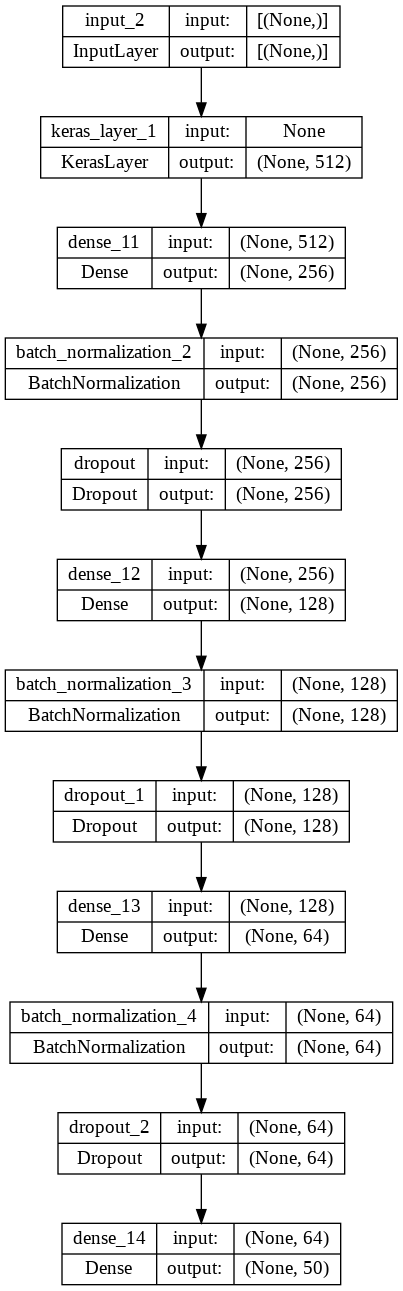

In [130]:
inputs = Input(shape=(), dtype=tf.string)
embedding = hub.KerasLayer(embed_usem, 
                    trainable = False)(inputs)
x = Dense(256, activation='relu')(embedding)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(64, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
outputs = Dense(num_class, activation='softmax')(x)

## Initialize the model
model_6 = Model(inputs, outputs, name = "Model_6_USEM") # construct the model

## Summarize layers
print(model_6.summary())

## Plot graph
plot_model(model_6, to_file='Model_6_USEM_plot.png', show_shapes=True, show_layer_names=True)

In [131]:
# Compile model
model_6.compile(loss = 'sparse_categorical_crossentropy',
                optimizer = Adam(lr = 0.0001),
                metrics = ["accuracy"])

# Fit the model
history_6 = model_6.fit(X_train_res,    ## note about X_train not like other model
                        y_train_res,
                        epochs = 30,
                        validation_data = (X_valid, y_valid)
                        )

Epoch 1/30
316/316 [==============================] - 14s 25ms/step - loss: 2.8857 - accuracy: 0.3935 - val_loss: 3.3800 - val_accuracy: 0.1987
Epoch 2/30
316/316 [==============================] - 6s 20ms/step - loss: 1.8172 - accuracy: 0.6241 - val_loss: 2.1774 - val_accuracy: 0.5569
Epoch 3/30
316/316 [==============================] - 6s 20ms/step - loss: 1.5304 - accuracy: 0.6727 - val_loss: 1.8325 - val_accuracy: 0.5922
Epoch 4/30
316/316 [==============================] - 6s 20ms/step - loss: 1.3766 - accuracy: 0.6965 - val_loss: 1.7159 - val_accuracy: 0.6092
Epoch 5/30
316/316 [==============================] - 6s 20ms/step - loss: 1.2686 - accuracy: 0.7120 - val_loss: 1.6297 - val_accuracy: 0.6222
Epoch 6/30
316/316 [==============================] - 6s 21ms/step - loss: 1.1922 - accuracy: 0.7284 - val_loss: 1.5774 - val_accuracy: 0.6209
Epoch 7/30
316/316 [==============================] - 6s 20ms/step - loss: 1.1361 - accuracy: 0.7326 - val_loss: 1.5359 - val_accuracy: 0.626

In [132]:
model_6_results = calculate_results(model_6,X_test, y_test)
model_6_results

27/27 [==============================] - 0s 16ms/step - loss: 1.3148 - accuracy: 0.7035


{'Test Accuracy %ge': 70.353, 'Test Loss Score': 1.31477}

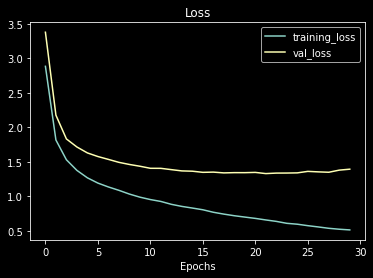

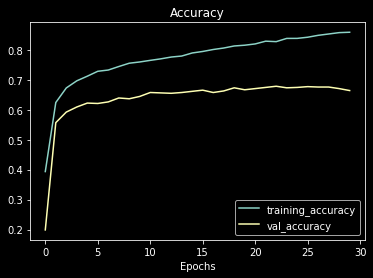

In [133]:
plot_loss_curves(history_6)

## Model_7: Electra_Large

In [134]:
## Downloading the BERT model
preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',trainable=False)
encoder =  hub.KerasLayer('https://tfhub.dev/google/electra_large/2',trainable=False)

In [135]:
## Initializing the BERT layers

inputs = Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = preprocess(inputs)
embedding = encoder(preprocessed_text)

print(embedding.keys())

pooled_output = embedding["pooled_output"]      # [batch_size, 768].
sequence_output = embedding["sequence_output"]  # [batch_size, seq_length, 768]

x = Dense(64, activation='relu',name="dense_layer_1")(pooled_output)
# x = BatchNormalization()(x)
# x = Dropout(0.1, name="dropout_1")(x)
# x = Dense(64, activation = 'relu', name="dense_layer_2")(x)

outputs = Dense(num_class, activation='softmax')(x)

## Initialize the model
model_7 = Model(inputs, outputs, name = "Model_7_ELECTRA")

## Summarize layers
print(model_7.summary())

# ## Plot graph
# plot_model(model_7, to_file='Model_7_ELECTRA_plot.png', show_shapes=True, show_dtype=True, show_layer_names=True)

dict_keys(['sequence_output', 'default', 'encoder_outputs', 'pooled_output'])
Model: "Model_7_ELECTRA"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
      

In [136]:
# Compile model
model_7.compile(loss = 'sparse_categorical_crossentropy',
                optimizer = Nadam(),
                metrics = ["accuracy"])

# Fit the model
history_7 = model_7.fit(X_train_res,    ## note about X_train not like other model
                        y_train_res,
                        epochs = 5,
                        validation_data = (X_valid, y_valid)
                        )

Epoch 1/5
316/316 [==============================] - 325s 976ms/step - loss: 1.6746 - accuracy: 0.6406 - val_loss: 1.9271 - val_accuracy: 0.5516
Epoch 2/5
316/316 [==============================] - 307s 972ms/step - loss: 1.2868 - accuracy: 0.7047 - val_loss: 1.8214 - val_accuracy: 0.5686
Epoch 3/5
316/316 [==============================] - 307s 971ms/step - loss: 1.2006 - accuracy: 0.7149 - val_loss: 1.7673 - val_accuracy: 0.5595
Epoch 4/5
316/316 [==============================] - 307s 971ms/step - loss: 1.1462 - accuracy: 0.7225 - val_loss: 1.7382 - val_accuracy: 0.5699
Epoch 5/5
316/316 [==============================] - 307s 971ms/step - loss: 1.1087 - accuracy: 0.7249 - val_loss: 1.7144 - val_accuracy: 0.5739


In [139]:
model_7_results = calculate_results(model_7,X_test, y_test)
model_7_results

27/27 [==============================] - 24s 884ms/step - loss: 1.6978 - accuracy: 0.6000


{'Test Accuracy %ge': 60.0, 'Test Loss Score': 1.69777}

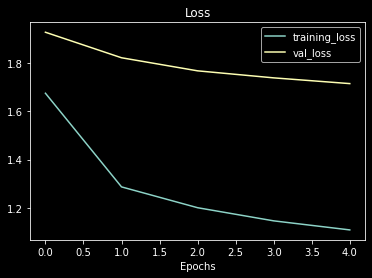

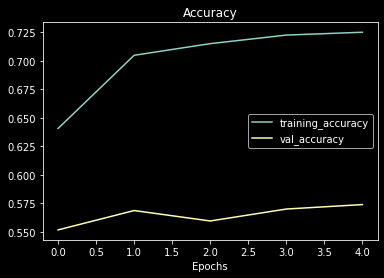

In [140]:
plot_loss_curves(history_7)

## Part_2: With Raw Data on Pretrained Multilanguage model

In [141]:
df2.shape

(8500, 2)

In [142]:
df2['Assignment_group'].value_counts()

GRP_0       3976
GRP_8        661
GRP_24       289
GRP_12       257
GRP_9        252
GRP_2        241
GRP_19       215
GRP_3        200
GRP_6        184
GRP_13       145
GRP_10       140
GRP_5        129
GRP_14       118
GRP_25       116
GRP_33       107
GRP_4        100
GRP_29        97
GRP_18        88
misc_grp      87
GRP_16        85
GRP_17        81
GRP_31        69
GRP_7         68
GRP_34        62
GRP_26        56
GRP_40        45
GRP_28        44
GRP_41        40
GRP_30        39
GRP_15        39
GRP_42        37
GRP_20        36
GRP_45        35
GRP_22        31
GRP_1         31
GRP_11        30
GRP_21        29
GRP_47        27
GRP_23        25
GRP_62        25
GRP_48        25
GRP_60        20
GRP_39        19
GRP_27        18
GRP_37        16
GRP_44        15
GRP_36        15
GRP_50        14
GRP_53        11
GRP_65        11
Name: Assignment_group, dtype: int64

In [143]:
sample = df2.groupby(['Assignment_group'])
regroup=[]
for grp in df2['Assignment_group'].unique():
  if(sample.get_group(grp).shape[0]<10):
    regroup.append(grp)
print('Found {} groups which have under 10 samples'.format(len(regroup)))
df2['Assignment_group']=df2['Assignment_group'].apply(lambda x : 'misc_grp' if x in regroup  else x)

Found 0 groups which have under 10 samples


In [144]:
# label_encoder object knows how to understand word labels. 
label_encoder = LabelEncoder()
df2['Assignment_group']= label_encoder.fit_transform(df2['Assignment_group'])

In [145]:
df2.shape, df2['Assignment_group'].nunique()

((8500, 2), 50)

In [146]:
from sklearn.preprocessing import KBinsDiscretizer
est_2 = KBinsDiscretizer(n_bins=50, encode='ordinal', strategy='uniform')
new_2 = est_2.fit_transform(df2[['Assignment_group']])

In [147]:
len(np.unique(new_2))

50

In [148]:
df2_dev, df2_test = train_test_split(df2, test_size = 0.1,stratify = new_2,  random_state = 42)

In [149]:
df2_dev.shape, df2_test.shape

((7650, 2), (850, 2))

In [150]:
est_2_2 = KBinsDiscretizer(n_bins=50, encode='ordinal', strategy='uniform')
new_2_2 = est_2_2.fit_transform(df2_dev[['Assignment_group']])

In [151]:
## Train and Valid split on Dev data
df2_train, df2_valid = train_test_split(df2_dev, test_size = 0.1,stratify = new_2_2, random_state = 42)

In [152]:
ros_2 = RandomOverSampler(random_state = 42,sampling_strategy='minority')
X_train_res_2, y_train_res_2 = ros_2.fit_resample(df2_train['Complete_Description'].values.reshape(-1, 1), df2_train['Assignment_group'].values.reshape(-1, 1))

In [153]:
X_train_res_2.shape, y_train_res_2.shape

((10096, 1), (10096,))

In [154]:
## Creating the feature space               
X_valid_2 = df2_valid.drop('Assignment_group',axis = 1)
X_test_2 = df2_test.drop('Assignment_group',axis = 1)

## Creating target variable                             
y_valid_2 = df2_valid['Assignment_group']
y_test_2 = df2_test['Assignment_group']

In [155]:
X_valid_2.shape,X_test_2.shape, y_valid_2.shape, y_test_2.shape

((765, 1), (850, 1), (765,), (850,))

In [156]:
num_class_2 = len(np.unique(y_train_res_2))
num_class_2

50

## Model_8: BERT Multi Language Cased on RAW Data

In [157]:
## Downloading the BERT model
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3",trainable=False)
bert_encoder =  hub.KerasLayer('https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4',trainable=False)

In [160]:
## Initializing the BERT layers

inputs = Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(inputs)
embedding = bert_encoder(preprocessed_text)

print(embedding.keys())

pooled_output = embedding["pooled_output"]      # [batch_size, 768].
sequence_output = embedding["sequence_output"]  # [batch_size, seq_length, 768]


x = Dense(64, activation = 'relu', name="dense_layer_2")(pooled_output)
x = Dropout(0.1, name="dropout_1")(x)

outputs = Dense(num_class_2, activation='softmax')(x)

## Initialize the model
model_8 = Model(inputs, outputs, name = "Model_8_BERT_RAW")

## Summarize layers
print(model_8.summary())

# ## Plot graph
# plot_model(model_6, to_file='Model_8_BERT_RAW_plot.png', show_shapes=True, show_dtype=True, show_layer_names=True)

dict_keys(['pooled_output', 'encoder_outputs', 'default', 'sequence_output'])
Model: "Model_8_BERT_RAW"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_4 (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
     

In [161]:
# Compile model
model_8.compile(loss = 'sparse_categorical_crossentropy',
                optimizer = Nadam(),
                metrics = ["accuracy"])

# Fit the model
history_8 = model_8.fit(X_train_res_2,
                        y_train_res_2,
                        epochs = 5,
                        validation_data = (X_valid_2, y_valid_2)
                        )

Epoch 1/5
316/316 [==============================] - 109s 338ms/step - loss: 2.1144 - accuracy: 0.5257 - val_loss: 2.5095 - val_accuracy: 0.3556
Epoch 2/5
316/316 [==============================] - 106s 335ms/step - loss: 1.6678 - accuracy: 0.6309 - val_loss: 2.1319 - val_accuracy: 0.5176
Epoch 3/5
316/316 [==============================] - 106s 335ms/step - loss: 1.4833 - accuracy: 0.6697 - val_loss: 2.0074 - val_accuracy: 0.5255
Epoch 4/5
316/316 [==============================] - 106s 335ms/step - loss: 1.3849 - accuracy: 0.6844 - val_loss: 1.9056 - val_accuracy: 0.5516
Epoch 5/5
316/316 [==============================] - 106s 335ms/step - loss: 1.3188 - accuracy: 0.6961 - val_loss: 1.8716 - val_accuracy: 0.5503


In [162]:
model_8_results = calculate_results(model_8,X_test_2, y_test_2)
model_8_results

27/27 [==============================] - 8s 305ms/step - loss: 1.8303 - accuracy: 0.5529


{'Test Accuracy %ge': 55.294, 'Test Loss Score': 1.83028}

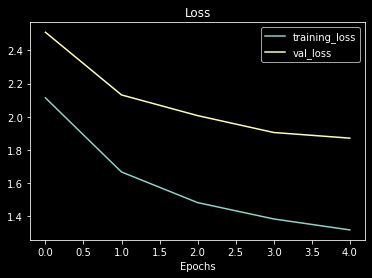

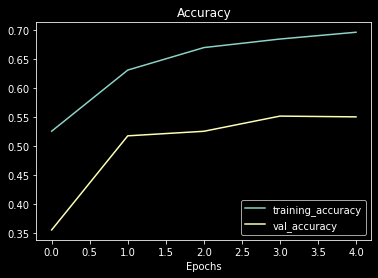

In [163]:
plot_loss_curves(history_8)

## Model_9: USEM on Raw Data

Model: "Model_9_USEM_RAW"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None,)]                 0         
                                                                 
 keras_layer_9 (KerasLayer)  (None, 512)               68927232  
                                                                 
 dense_30 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization_8 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_31 (Dense)            (None, 128)               32896     
                                                  

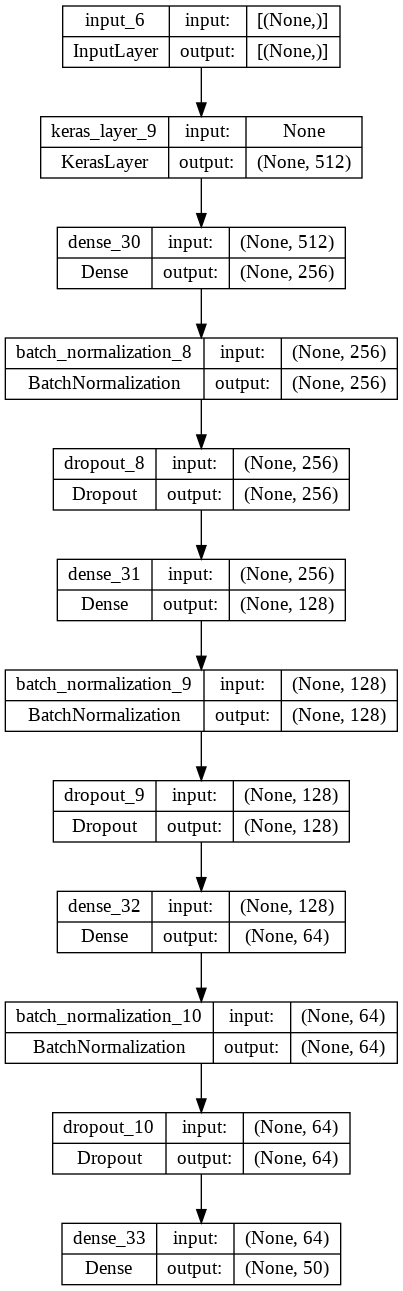

In [181]:
inputs = Input(shape=(), dtype=tf.string)
embedding = hub.KerasLayer(embed_usem, 
                    trainable = False)(inputs)
x = Dense(256, activation='relu')(embedding)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(64, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

outputs = Dense(num_class, activation='softmax')(x)

## Initialize the model
model_9 = Model(inputs, outputs, name = "Model_9_USEM_RAW") # construct the model

## Summarize layers
print(model_9.summary())

## Plot graph
plot_model(model_9, to_file='Model_9_USEM_RAW_plot.png', show_shapes=True, show_layer_names=True)

In [189]:
# Compile model
model_9.compile(loss = 'sparse_categorical_crossentropy',
                optimizer = RMSprop(lr = 0.0005),
                metrics = ["accuracy"])

# Fit the model
history_9 = model_9.fit(X_train_res_2,
                        y_train_res_2,
                        epochs = 25,
                        validation_data = (X_valid_2, y_valid_2)
                        )

Epoch 1/25
316/316 [==============================] - 11s 24ms/step - loss: 0.5114 - accuracy: 0.8644 - val_loss: 1.6019 - val_accuracy: 0.6601
Epoch 2/25
316/316 [==============================] - 6s 20ms/step - loss: 0.4999 - accuracy: 0.8633 - val_loss: 1.5549 - val_accuracy: 0.6575
Epoch 3/25
316/316 [==============================] - 6s 20ms/step - loss: 0.4858 - accuracy: 0.8666 - val_loss: 1.5670 - val_accuracy: 0.6641
Epoch 4/25
316/316 [==============================] - 6s 20ms/step - loss: 0.4650 - accuracy: 0.8752 - val_loss: 1.6347 - val_accuracy: 0.6379
Epoch 5/25
316/316 [==============================] - 7s 21ms/step - loss: 0.4241 - accuracy: 0.8828 - val_loss: 1.6220 - val_accuracy: 0.6562
Epoch 6/25
316/316 [==============================] - 7s 21ms/step - loss: 0.4060 - accuracy: 0.8876 - val_loss: 1.5530 - val_accuracy: 0.6588
Epoch 7/25
316/316 [==============================] - 7s 21ms/step - loss: 0.3904 - accuracy: 0.8941 - val_loss: 1.6366 - val_accuracy: 0.651

In [190]:
model_9_results = calculate_results(model_9,X_test_2, y_test_2)
model_9_results

27/27 [==============================] - 1s 20ms/step - loss: 1.6116 - accuracy: 0.7212


{'Test Accuracy %ge': 72.118, 'Test Loss Score': 1.61159}

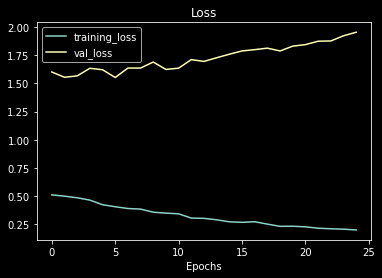

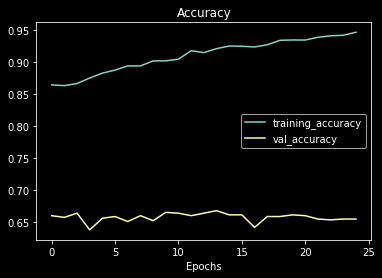

In [191]:
plot_loss_curves(history_9)

## Comparing the peformance of each of our models

In [192]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"Model_1_Simple_ANN": model_1_results,
                                  "Model_2_LSTM": model_2_results,
                                  "Model_3_GRU": model_3_results,
                                  "Model_4_Bidriectional_RNN": model_4_results,
                                  "Model_5_USEL": model_5_results,
                                  "Model_6_USEM": model_6_results,
                                  "Model_7_ELECTRA": model_7_results,
                                  "Model_8_BERT_Mul_Case_Raw": model_8_results,
                                  "Model_9_USEM_Raw": model_9_results
                                  })
all_model_results = all_model_results.T
all_model_results

,Test Accuracy %ge,Test Loss Score
Model_1_Simple_ANN,66.471,1.55730
Model_2_LSTM,64.235,3.15030
Model_3_GRU,66.235,3.08186
Model_4_Bidriectional_RNN,64.235,2.09015
Model_5_USEL,64.353,1.52984
Model_6_USEM,70.353,1.31477
Model_7_ELECTRA,60.000,1.69777
Model_8_BERT_Mul_Case_Raw,55.294,1.83028
Model_9_USEM_Raw,72.118,1.61159


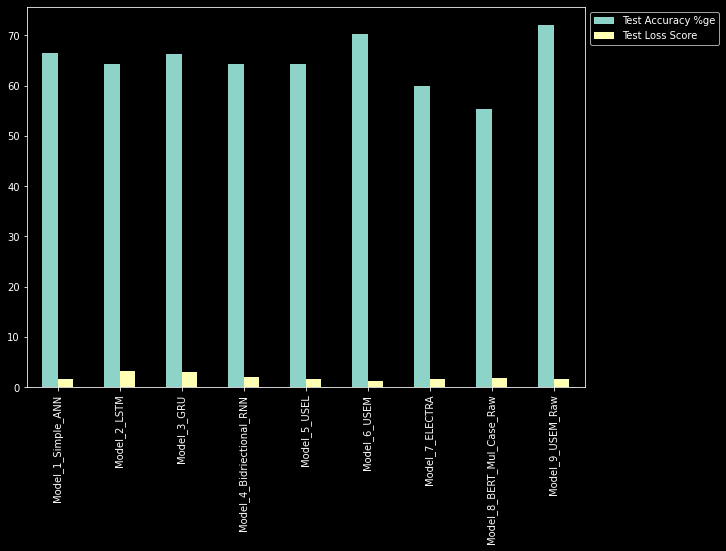

In [193]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

** END **

In [ ]:
# pip install googletrans

# pip install langdetect

# from langdetect import detect

# pip install langid

# # import libraries we'll use
# import langid # language identification (i.e. what language is this?)
# # from nltk.classify.textcat import TextCat # language identification from NLTK

# # get the language id for each text
# ids_langid = df1['Complete_Description'].apply(langid.classify)

# # get just the language label
# langs = ids_langid.apply(lambda tuple: tuple[0])

# # how many unique language labels were applied?
# print("Number of tagged languages (estimated):")
# print(len(langs.unique()))

# # percent of the total dataset in English
# print("Percent of data in English (estimated):")
# print((sum(langs=="en")/len(langs))*100)


# from googletrans import Translator, LANGUAGES,constants
# from pprint import pprint

# # print all available languages
# print("Total supported languages:", len(constants.LANGUAGES))
# print("Languages:")
# pprint(constants.LANGUAGES)

# def detect_lang(text):
#   return detect(text)

# x =  df1['Complete_Description'].apply(detect_lang).nunique()   
# print(f"Total number of unique value present is {x}")
# print(f"{df1['Complete_Description'].apply(detect_lang).value_counts()}")


# pip install googletrans==3.1.0a0


# # Create a translator object:
# translator = Translator()

# # Use translate method to translate the column. 
# df1['Translated_description'] = df1['Complete_Description'].apply(translator.translate,dest='en').apply(getattr, args=('text',))



# print("German (Before Translation):",df1['Complete_Description'][1622])
# print('\nEnglish (After Translation): '+df1['Translated_description'][1622])

# print("Chinese (Before Translation):",df1['Complete_Description'][164])
# print('\nEnglish (After Translation): '+df1['Translated_description'][164])

# df1.info()

# # Drop the complete description Column
# df1 = df1.drop(['Complete_Description'], 1)

In [ ]:
# import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# from nltk.tokenize import RegexpTokenizer
# from nltk.stem import WordNetLemmatizer,PorterStemmer
# from nltk.corpus import stopwords
# import re
# import string

# from sklearn.model_selection import train_test_split
# from collections import OrderedDict

# from wordcloud import WordCloud, STOPWORDS # this module is for making wordcloud in python


# from dateutil import parser
# def is_valid_date(date_str):
#     try:
#         parser.parse(date_str)
#         return True
#     except:
#         return False
# def clean_data(text):
#     text=str(text).lower()
#     text = ' '.join([w for w in text.split() if not is_valid_date(w)])
#     text = re.sub(r"received from:",' ',text)
#     text = re.sub(r"from:",' ',text)
#     text = re.sub(r"to:",' ',text)
#     text = re.sub(r"subject:",' ',text)
#     text = re.sub(r"sent:",' ',text)
#     text = re.sub(r"ic:",' ',text)
#     text = re.sub(r"cc:",' ',text)
#     text = re.sub(r"bcc:",' ',text)
#     #Remove email 
#     text = re.sub(r'\S*@\S*\s?', '', text)
#     # Remove numbers 
#     text = re.sub(r'\d+','' ,text)
#     # Remove Non Dictionary character-TODO
#     # Remove new line characters 
#     text = re.sub(r'\n',' ',text)
#     # Remove hashtag while keeping hashtag text
#     text = re.sub(r'#','', text)
#     #& 
#     text = re.sub(r'&;?', 'and',text)
#     # Remove HTML special entities (e.g. &amp;)
#     text = re.sub(r'\&\w*;', '', text)
#     # Remove hyperlinks
#     text = re.sub(r'https?:\/\/.*\/\w*', '', text)  
#     # Remove characters beyond Readable formart by Unicode:
#     text= ''.join(c for c in text if c <= '\uFFFF') 
#     text = text.strip()
#     # Remove unreadable characters  (also extra spaces)
#     text = ' '.join(re.sub("[^\u0030-\u0039\u0041-\u005a\u0061-\u007a]", " ", text).split())
          
#     text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
#     text = re.sub(' +', ' ', text)
#     text = text.strip()
#     return np.array(text)
  
# X_train_res = clean_data(X_train_res)




# X_train = X_train_res.ravel().reshape(-1, 1)
# y_train = y_train_res.ravel()
# X_train.shape
# X_train = pd.DataFrame(X_train)
# X_train.shape, y_train.shape
# X_valid.shape, y_valid.shape
# X_train.dtypes
# X_train.info()



# vectorizer = TfidfVectorizer(analyzer='word', max_features=50000,lowercase = False)
# X_train = vectorizer.fit_transform(X_train)
# X_valid = vectorizer.transform(X_valid)

# # Create tokenization and modelling pipeline
# model_0_nb = Pipeline([
#                     ("tfidf", TfidfVectorizer( max_features=50000,lowercase = False)), # convert words to numbers using tfidf
#                     ("clf", MultinomialNB()) # model the text converted to numbers
# ])

# # Fit the pipeline to the training data
# model_0_nb.fit(X_train, y_train)

# ## Evaluate
# baseline_score_trn_nb = model_0_nb.score(X_train, y_train)
# print(f"Our baseline NB model achieves an train accuracy of: {baseline_score_trn_nb*100:.2f}%")
# print('')
# ## Evaluate
# baseline_score_valid_nb = model_0_nb.score(X_valid, y_valid)
# print(f"Our baseline NB model achieves an valid accuracy of: {baseline_score_trn_nb*100:.2f}%")

###
# # Find the average number of tokens (words) in the training tweets

# round(sum([len(i.split()) for i in X_train_arr.ravel()])/len(X_train_arr.ravel()))